In [114]:
import json
from pathlib import Path
from itertools import islice
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import seaborn as sns

In [23]:
#Load json.
def load_dataset(path: Path):
    with open(path, 'r') as data_file:
        for line in data_file:
            yield json.loads(line)
        

In [24]:
#Import data
Beauty = load_dataset(Path('/Users/linxisarah/Desktop/DV_MidTerm/amazon_data/Beauty/All_Beauty.json'))
mBeauty = load_dataset(Path('/Users/linxisarah/Desktop/DV_MidTerm/amazon_data/Beauty/meta_All_Beauty.json'))
LuxuryB = load_dataset(
    Path('/Users/linxisarah/Desktop/DV_MidTerm/amazon_data/Luxury_Beauty/Luxury_Beauty.json'))
mLuxuryB = load_dataset(
    Path('/Users/linxisarah/Desktop/DV_MidTerm/amazon_data/Luxury_Beauty/meta_Luxury_Beauty.json'))

In [25]:
#I have just used these two datasets so far, you are free to use the others
Beauty = pd.DataFrame(Beauty)
mBeauty = pd.DataFrame(mBeauty)

In [26]:
#Tidy the data
Beauty = Beauty.loc[:, ['asin', 'overall', 'reviewTime','verified']]
BeautyT = Beauty[Beauty['verified'] == True]
BeautyT.drop(['verified'], axis = 1, inplace = True)

mBeauty = mBeauty.loc[:, ['asin', 'title', 'price', 'brand', 'main_cat']]
DF = pd.merge(BeautyT, mBeauty, how = "inner", on = "asin")
DF['reviewTime'] = pd.to_datetime(DF.reviewTime)

,asin,overall,reviewTime
0,0143026860,1.0,"02 19, 2015"
1,0143026860,4.0,"12 18, 2014"
2,0143026860,4.0,"08 10, 2014"
3,0143026860,5.0,"03 11, 2013"
4,0143026860,5.0,"12 25, 2011"
...,...,...,...
371340,B01HJEGTYK,1.0,"07 20, 2017"
371341,B01HJEGTYK,5.0,"03 16, 2017"
371342,B01HJEGTYK,5.0,"03 1, 2017"
371343,B01HJEGTYK,2.0,"02 21, 2017"


In [28]:
#Just a reminder here
if BeautyT.shape[0] < DF.shape[0]:
    print("Some reviews are of products are not in the metadata")

Some reviews are of products are not in the metadata


In [29]:
#Set-up the time range
def add_first_review_time(data):
    min_review_time = min(data['reviewTime'])
    max_review_time = max(data['reviewTime'])
    data['firstReviewTime'] = min_review_time
    if ((max_review_time - min_review_time) / np.timedelta64(1, 'M')) >= 6:
        reviewed_by_at_least_six_motnths = True
    else:
        reviewed_by_at_least_six_motnths = False
    data['reviewedByAtLeastSixMotnths'] = reviewed_by_at_least_six_motnths
    return data

In [30]:
DF = DF.groupby('asin').apply(add_first_review_time)

In [31]:
DF['numMonthsSinceFirstReview'] = ((DF['reviewTime'] - DF['firstReviewTime']) / np.timedelta64(1, 'M')).astype(int)

In [32]:
#Sorted data
DF

,asin,overall,reviewTime,title,price,brand,main_cat,firstReviewTime,reviewedByAtLeastSixMotnths,numMonthsSinceFirstReview
0,0143026860,1.0,2015-02-19,Black Diamond,NaN,Swedish Beauty,All Beauty,2011-12-25,True,37
1,0143026860,4.0,2014-12-18,Black Diamond,NaN,Swedish Beauty,All Beauty,2011-12-25,True,35
2,0143026860,4.0,2014-08-10,Black Diamond,NaN,Swedish Beauty,All Beauty,2011-12-25,True,31
3,0143026860,5.0,2013-03-11,Black Diamond,NaN,Swedish Beauty,All Beauty,2011-12-25,True,14
4,0143026860,5.0,2011-12-25,Black Diamond,NaN,Swedish Beauty,All Beauty,2011-12-25,True,0
...,...,...,...,...,...,...,...,...,...,...
335862,B01HJ84SGM,5.0,2017-10-03,NOW D-Mannose 500 mg - 120 Veg Capsules (Pack ...,$55.63,NaN,All Beauty,2017-05-09,True,4
335863,B01HJ84SGM,5.0,2017-08-24,NOW D-Mannose 500 mg - 120 Veg Capsules (Pack ...,$55.63,NaN,All Beauty,2017-05-09,True,3
335864,B01HJ84SGM,5.0,2017-05-29,NOW D-Mannose 500 mg - 120 Veg Capsules (Pack ...,$55.63,NaN,All Beauty,2017-05-09,True,0
335865,B01HJ84SGM,5.0,2017-05-09,NOW D-Mannose 500 mg - 120 Veg Capsules (Pack ...,$55.63,NaN,All Beauty,2017-05-09,True,0


In [96]:
#Select the products which have been reviewed more than 6 month and only take the data for the first 6 month.
DFx = DF[(DF['reviewedByAtLeastSixMotnths'] == True) & (DF['numMonthsSinceFirstReview'] <=6)]
DFx

,asin,overall,reviewTime,title,price,brand,main_cat,firstReviewTime,reviewedByAtLeastSixMotnths,numMonthsSinceFirstReview
4,0143026860,5.0,2011-12-25,Black Diamond,NaN,Swedish Beauty,All Beauty,2011-12-25,True,0
19,014789302X,5.0,2016-09-26,"12 Pc BLUE HEAVEN KAJAL""HERBAL kajal With VITA...",$6.45,BLUE HEAVE,All Beauty,2016-03-26,True,6
20,014789302X,4.0,2016-08-05,"12 Pc BLUE HEAVEN KAJAL""HERBAL kajal With VITA...",$6.45,BLUE HEAVE,All Beauty,2016-03-26,True,4
21,014789302X,5.0,2016-07-29,"12 Pc BLUE HEAVEN KAJAL""HERBAL kajal With VITA...",$6.45,BLUE HEAVE,All Beauty,2016-03-26,True,4
22,014789302X,5.0,2016-06-18,"12 Pc BLUE HEAVEN KAJAL""HERBAL kajal With VITA...",$6.45,BLUE HEAVE,All Beauty,2016-03-26,True,2
...,...,...,...,...,...,...,...,...,...,...
335857,B01HIUEEHO,5.0,2016-10-03,Pokemon Plush 9.2 Inch / 23cm Gengar Doll Stuf...,$20.74,NaN,All Beauty,2016-10-03,True,0
335862,B01HJ84SGM,5.0,2017-10-03,NOW D-Mannose 500 mg - 120 Veg Capsules (Pack ...,$55.63,NaN,All Beauty,2017-05-09,True,4
335863,B01HJ84SGM,5.0,2017-08-24,NOW D-Mannose 500 mg - 120 Veg Capsules (Pack ...,$55.63,NaN,All Beauty,2017-05-09,True,3
335864,B01HJ84SGM,5.0,2017-05-29,NOW D-Mannose 500 mg - 120 Veg Capsules (Pack ...,$55.63,NaN,All Beauty,2017-05-09,True,0


In [105]:
#Count the frequency of reviews in each month for each product
DF_Count = DFx.groupby(["asin", "numMonthsSinceFirstReview"]).size().reset_index(name="Count")

,asin,numMonthsSinceFirstReview,Count
0,0143026860,0,1
1,014789302X,0,1
2,014789302X,1,1
3,014789302X,2,1
4,014789302X,4,2
...,...,...,...
33274,B01HJ84SGM,4,1
33275,B01HJEGTYK,0,1
33276,B01HJEGTYK,1,1
33277,B01HJEGTYK,3,2


In [14]:
DF['reviewTime'][0] - DF['firstReviewTime'][0]

Timedelta('1152 days 00:00:00')

In [126]:
#Calculate the mean value of review of each month
DF_Count.loc[:, 'Mean'] = DF_Count.groupby(['numMonthsSinceFirstReview'])['Count'].transform(np.mean)
DF_Count.loc[:, 'MonthSum'] = DF_Count.groupby(['numMonthsSinceFirstReview'])['Count'].transform(np.sum)
DF_Count

,asin,numMonthsSinceFirstReview,Count,Mean,MonthSum
0,0143026860,0,1,1.452698,20162
1,014789302X,0,1,1.452698,20162
2,014789302X,1,1,2.304653,7232
3,014789302X,2,1,2.417555,7712
4,014789302X,4,2,2.390533,7676
...,...,...,...,...,...
33274,B01HJ84SGM,4,1,2.390533,7676
33275,B01HJEGTYK,0,1,1.452698,20162
33276,B01HJEGTYK,1,1,2.304653,7232
33277,B01HJEGTYK,3,2,2.370324,7540


(0, 5)

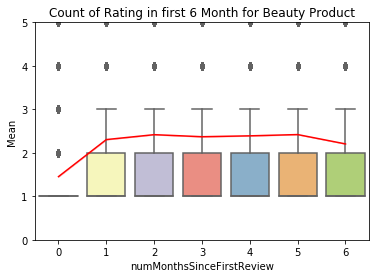

In [127]:
#Just some plots attempts...
##Boxplot
sns.boxplot(x="numMonthsSinceFirstReview", y="Count", data = DF_Count, palette="Set3", linewidth=1.5).set(
xlabel='Review Month', ylabel='Count of Rating', 
    title = "Count of Rating in first 6 Month for Beauty Product")

sns.lineplot(y= DF_Count.Mean,x = DF_Count.numMonthsSinceFirstReview, color = "red")


plt.ylim(0,5)


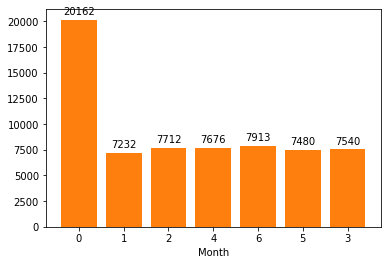

In [159]:
##Barchart

x = np.arange(7)
y = list(DF_Count.MonthSum.unique())

fig, ax = plt.subplots()

plt.bar(x, y)
plt.xlabel('Month')
plt.xticks(x, DF_Count.numMonthsSinceFirstReview.unique())



def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(plt.bar(x, y))

plt.show()

In [154]:
A = pd.DataFrame(data = (DF_Count.MonthSum.unique(), DF_Count.numMonthsSinceFirstReview.unique())).T
A.sort_values(by = [1])

,0,1
0,20162,0
1,7232,1
2,7712,2
6,7540,3
3,7676,4
5,7480,5
4,7913,6


In [148]:
A = list(DF_Count.MonthSum.unique())
A.sort()
A

[7232, 7480, 7540, 7676, 7712, 7913, 20162]

In [92]:
df.groupby(["p", "q"]).size()

p  q
a  1    2
   2    1
b  1    1
s  3    2
dtype: int64

In [106]:
df = pd.DataFrame({'p':('a','a','b','a','s','s'), 'q':(1,2,1,1,3,3)})

,p,q
0,a,1
1,a,2
2,b,1
3,a,1
4,s,3
5,s,3


In [108]:
df = df.groupby(["p", "q"]).size().reset_index(name="F")

,p,q,F
0,a,1,2
1,a,2,1
2,b,1,1
3,s,3,2


In [109]:
df['mean'] = df.groupby(['q'])['F'].transform(np.mean)
df

,p,q,F,mean
0,a,1,2,1.5
1,a,2,1,1.0
2,b,1,1,1.5
3,s,3,2,2.0


In [60]:
df['freq'] = df.groupby('p')['q'].transform(np.sum)
df

,p,q,freq
0,a,1,11
1,b,2,223
2,s,1,11
3,s,1,11
4,b,2,223
5,a,1,11
6,b,3,223
